# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  

______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Wrangle


In [4]:
df = pd.read_csv('store_item_demand.csv')
df.head().T

,0,1,2,3,4
sale_id,1,2,3,4,5
sale_date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05
store_id,1,1,1,1,1
item_id,1,1,1,1,1
sale_amount,13,11,14,13,10
item_brand,Riceland,Riceland,Riceland,Riceland,Riceland
item_name,Riceland American Jazmine Rice,Riceland American Jazmine Rice,Riceland American Jazmine Rice,Riceland American Jazmine Rice,Riceland American Jazmine Rice
item_price,0.84,0.84,0.84,0.84,0.84
store_address,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy,12125 Alamo Ranch Pkwy
store_zipcode,78253,78253,78253,78253,78253



1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [7]:
def prep_data(df):
    return (df.assign(ds = pd.to_datetime(df.sale_date)).
            # sort values by date
            sort_values('ds').
            # create dollars_sold column
            assign(dollars_sold = df.sale_amount * df.item_price).
            # sale_amount to be items_sold
            assign(items_sold = df.sale_amount).
            # aggregate daily by summing the values
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().
            # set index to date
            reset_index().set_index('ds')
           )

In [ ]:
df = prep_data(df)

In [10]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [11]:
# remove leap days

df = df[df.index != '2016-02-29']


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [12]:
train_size = int(len(df) * .5)
train_size

912

In [13]:
validate_size = int(len(df) * .3)
validate_size

547

In [14]:
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [15]:
validate_end_index = train_size + validate_size
validate_end_index

1459

Use those values to split our dataframe

In [16]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [17]:
print(len(train) + len(validate) + len(test) == len(df))

True


Does the first row of original df equate to the first row of train? 

In [18]:
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [19]:
pd.concat([train.tail(1), validate.head(1)])


,dollars_sold,items_sold
ds,,
2015-07-01,164573.20,30703
2015-07-02,178036.64,33134


In [20]:
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30,120033.64,22296
2016-12-31,128009.31,23792


Is the last row of test the same as the last row of our original dataframe? 

In [21]:
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31,140905.74,26420
2017-12-31,140905.74,26420


Let's plot our data first, viewing where the data is split into train and test. 

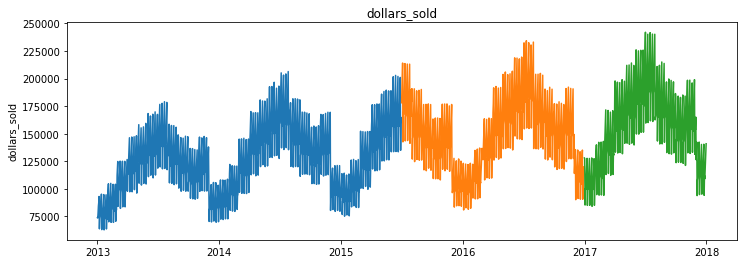

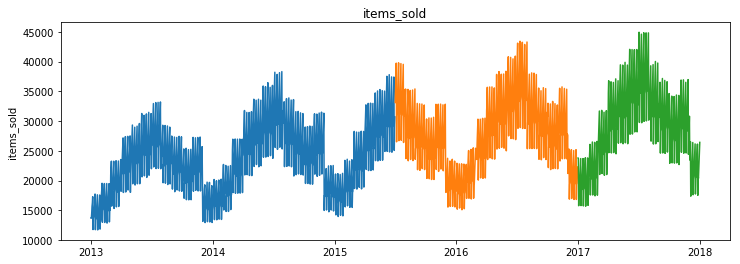

In [27]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [ ]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [ ]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plot.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value
2. Simple Average
3. Moving Average
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

Let's try out several other values for periods:

Which is best so far? 

### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

**Plot Actual vs. Predicted Values**

**Evaluate**

### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

**Make Predictions**

**Plot and Evaluate**

## Conclusion

Which model did the best? 

Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.